In [1]:
import sys
import time

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj

from pygsp.graphs import Graph
import networkx as nx

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.model import select_model, Model
from graph_deep_decoder.architecture import Ups
from graph_deep_decoder.graph_clustering import MultiResGraphClustering

# %matplotlib qt

SEED = 0
PATH = './results/cora/'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Auxiliary functions

In [ ]:
def get_best_err(err):
    mean_err = np.mean(err, axis=1)
    std = np.std(err, axis=1)
    best_epochs_mean = np.argmin(mean_err, axis=2)
    best_mean_err = np.zeros((len(N_P), len(Exps)))
    best_std = np.zeros((len(N_P), len(Exps)))
    for i in range(len(N_P)):
        for j in range(len(Exps)):
            best_mean_err[i, j] = mean_err[i, j, best_epochs_mean[i, j]]
            best_std[i, j] = std[i, j, best_epochs_mean[i, j]]

    return best_mean_err, best_std, best_epochs_mean,


def plot_noise_err(err, legend, ylabel):
    fig = plt.figure()
    plt.semilogy(N_P, err, linewidth=4)
    plt.legend(legend, prop={'size': 12})
    plt.grid(True, which='both')
    plt.xlabel('Normalized noise power',fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.xlim([N_P[0], N_P[-1]])
    # plt.ylim([1e-3, 0.2])
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    return fig


def print_err(err, std, weights):
    print('N_P:', N_P)
    for j, exp in enumerate(Exps):
        text = '{} ({}): '.format(exp['legend'], weights[j])
        for i, n_p in enumerate(N_P):
            text += '\t{:.4f} +- {:.4f}'.format(err[i, j], std[i, j]) 
        print(text)

def plot_iter_err(err, label):
    figs = []
    for i, n_p in enumerate(N_P):
        err_np = err[i]
        figs.append(plt.figure())
        plt.semilogy(err_np.T)
        plt.grid(True, which='both')
        plt.legend(legend)
        plt.title('{}: {}'.format(label, n_p))
        plt.xlim(left=0, right=err.shape[-1])
        plt.tight_layout()
        
    return figs


def print_err_all0(labels):
    x_zero = np.zeros(labels.shape[0])
    err = np.zeros(np.unique(labels).shape[0])
    for label in labels:
        x = np.where(labels == label, 1, 0)
        err[label-1] = np.sum(x != x_zero)/labels.shape[0]

    print('Err per label:', err)
    print('Mean Err:', np.mean(err))


def compute_matrices(Exps, plot_clts=False):
    for exp in Exps:
        if exp['type'] == 'DD' and exp['legend'] == 'GD':
            clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0], link_fun='average')
            exp['nodes'] = clt.sizes
            exp['Us'] = clt.Us
            exp['As'] = clt.As

            if plot_clts:
                clt.plot_labels()

        elif exp['type'] == 'DD' and exp['legend'] == 'GCG':
            H = utils.create_filter(S, exp['h_params'])
            exp['Us'] =[H]*(len(exp['nodes'])-2) + [None]
            exp['As'] = []


def denoise_signals(labels, n_signals, Exps, epochs, lr):
    unique_labels = np.unique(labels)
    print('Labels:', unique_labels)
    n_labels = len(unique_labels)

    err = np.zeros((len(N_P), n_labels*n_signals, len(Exps), epochs))
    weights = np.zeros(len(Exps))
    for i, n_p in enumerate(N_P):
        print('Noise:', n_p)

        for l, label in enumerate(unique_labels):
            x = np.zeros(G.N)
            x[labels == label] = 1

            for j in range(n_signals):
                idx = l*n_signals + j
                x_n = ds.GraphSignal.add_bernoulli_noise(x, n_p)

                for k, exp in enumerate(Exps):
                    model = select_model(exp, x_n, epochs, lr, device)

                    if type(model) == Model:
                        weights[k] = model.count_params()
                        _, err[i, idx, k], _ = model.fit(x_n, x, class_val=True, device=device)
                    else:
                        model.fit(x_n)
                        _, err_non_train = model.test_classification(x)
                        err[i, idx, k] = np.repeat(err_non_train, epochs)

                    print(f'({l},{j})', end=' ')
    return err, weights

## Load dataset (whole graph)

Number of nodes: 2708
Number of edges: 10556
Number of classes: 7
Conn Comp: 78


Text(0.5, 1.0, 'Original graph')

<Figure size 432x288 with 0 Axes>

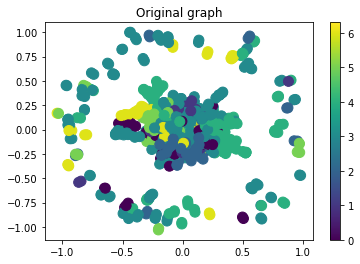

In [3]:
dataset = Planetoid(root='./tmp/Cora', name='Cora')
data = dataset[0]

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of classes: {dataset.num_classes}')

A = to_dense_adj(data.edge_index).numpy()[0,:,:]
L = np.diag(np.sum(A, axis=0)) - A
lambdas, V = np.linalg.eigh(L)
lambdas = np.real(lambdas)
print('Conn Comp:', np.sum(np.abs(lambdas) <= 1e-6))

labels = data.y

S = A

G = Graph(A)
G.set_coordinates()
plt.figure()
G.plot_signal(labels.numpy())
plt.title('Original graph')


## Set the expetiments

In [4]:
N_P = [.3]

# Model parameters
epochs =  500
lr = 0.001
loss = nn.MSELoss

Exps = [
        # CVX methods
        {'type': 'BL', 'S': A, 'alpha': .05, 'legend': 'BL'},
        {'type': 'TV', 'A': A, 'alpha': 5, 'legend': 'TV'},        
        {'type': 'LR', 'L': L, 'alpha': 15, 'legend': 'LR'},
        {'type': 'GTF', 'A': A, 'k': 3, 'lamb': .25, 'legend': 'GTF'},

        # Non-convex
        {'type': 'MED', 'S': A, 'legend': 'MED'},
        {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': 1, 'last_act': nn.Sigmoid(),
         'loss': loss(reduction='none'), 'legend': 'GCNN'},
        {'type': 'GAT', 'fts': 70, 'A': A, 'heads': 3, 'last_fts': 1, 'last_act': nn.Sigmoid(),
         'loss': loss(reduction='none'), 'legend': 'GAT'},
        {'type': 'KronAE', 'fts': 50, 'A': A, 'r': .5, 'last_act': nn.Sigmoid(),
         'loss': loss(reduction='none'), 'legend': 'K-GAE'},

        # Our models
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [100]*3 + [1],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.3, .5, .2], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 1600, 2000] + [G.N]*2, 'fts': [50]*5 + [1],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': 0, 
         'loss': loss(reduction='none'), 'legend': 'GD'},
        ]

legend = [exp['legend'] for _, exp in enumerate(Exps)]

compute_matrices(Exps)


## Denoising signals (whole graph)

In [6]:
n_signals = 25

start_time = time.time()
err, weights = denoise_signals(labels, n_signals, Exps, epochs, lr)
print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Labels: [0 1 2 3 4 5 6]
Noise: 0.3
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
--- 7.163784809907278 minutes ---


### Plot results

Err per label: [0.08013294 0.15435746 0.30206795 0.15731167 0.11004431 0.06646972
 0.12961595]
Mean Err: 0.14285714285714285
N_P: [0.3]
BL (0.0): 	0.1577 +- 0.0532
TV (0.0): 	0.1420 +- 0.0711
LR (0.0): 	0.1057 +- 0.0262
GTF (0.0): 	0.1252 +- 0.0199
MED (0.0): 	0.1708 +- 0.0283
GCNN (5926.0): 	0.1034 +- 0.0443
GAT (16101.0): 	0.1342 +- 0.0527
K-GAE (5251.0): 	0.1362 +- 0.0344
GCG (20100.0): 	0.0885 +- 0.0378
GD (10050.0): 	0.1139 +- 0.0332

N_P: [0.3]
BL (0.0): 	0.1577 +- 0.0532
TV (0.0): 	0.1420 +- 0.0711
LR (0.0): 	0.1057 +- 0.0262
GTF (0.0): 	0.1252 +- 0.0199
MED (0.0): 	0.1708 +- 0.0283
GCNN (5926.0): 	0.1922 +- 0.0173
GAT (16101.0): 	0.2925 +- 0.0113
K-GAE (5251.0): 	0.1558 +- 0.0336
GCG (20100.0): 	0.2291 +- 0.0164
GD (10050.0): 	0.1188 +- 0.0315


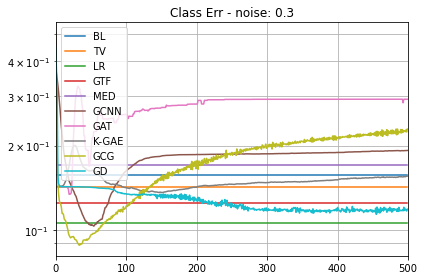

In [7]:
best_mean_err, std, _ = get_best_err(err)
fixed_mean_err = np.mean(err, axis=1)[:, :, -1]
fixed_std = np.std(err, axis=1)[:, :, -1]

print_err_all0(labels)
print_err(best_mean_err, std, weights)
print()
print_err(fixed_mean_err, fixed_std, weights)

figs = plot_iter_err(np.mean(err, axis=1), 'Class Err - noise')

## Considering main connected component

Number of nodes: 2485
Number of edges: 5069
Number of classes: 7
Conn Comp: 1


Text(0.5, 1.0, 'Original graph')

<Figure size 432x288 with 0 Axes>

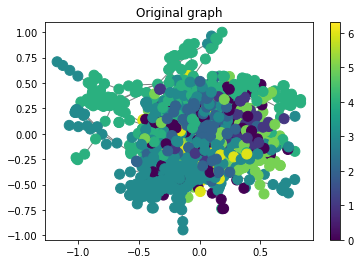

In [9]:
A_whole = to_dense_adj(data.edge_index).numpy()[0,:,:]
G_whole = nx.to_networkx_graph(A_whole)
nodes_cc = list(max(nx.connected_components(G_whole), key=len))
G_cc = G_whole.subgraph(nodes_cc).copy()

print(f'Number of nodes: {G_cc.number_of_nodes()}')
print(f'Number of edges: {G_cc.number_of_edges()}')
print(f'Number of classes: {dataset.num_classes}')

A = nx.to_numpy_array(G_cc)
L = np.diag(np.sum(A, axis=0)) - A
lambdas, V = np.linalg.eigh(L)
lambdas = np.real(lambdas)
print('Conn Comp:', np.sum(np.abs(lambdas) <= 1e-6))

labels = data.y[nodes_cc]

S = A

G = Graph(A)
G.set_coordinates()
plt.figure()
G.plot_signal(labels.numpy())
plt.title('Original graph')


### Set the expetiments

In [10]:
N_P = [.3]

# Model parameters
epochs =  500
lr = 0.001
loss = nn.MSELoss

Exps = [
        # CVX methods
        {'type': 'BL', 'S': A, 'alpha': .05, 'legend': 'BL'},
        {'type': 'TV', 'A': A, 'alpha': 5, 'legend': 'TV'},        
        {'type': 'LR', 'L': L, 'alpha': 15, 'legend': 'LR'},
        {'type': 'GTF', 'A': A, 'k': 3, 'lamb': .25, 'legend': 'GTF'},

        # Non-convex
        {'type': 'MED', 'S': A, 'legend': 'MED'},
        {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': 1, 'last_act': nn.Sigmoid(),
         'loss': loss(reduction='none'), 'legend': 'GCNN'},
        {'type': 'GAT', 'fts': 70, 'A': A, 'heads': 3, 'last_fts': 1, 'last_act': nn.Sigmoid(),
         'loss': loss(reduction='none'), 'legend': 'GAT'},
        {'type': 'KronAE', 'fts': 50, 'A': A, 'r': .5, 'last_act': nn.Sigmoid(),
         'loss': loss(reduction='none'), 'legend': 'K-GAE'},

        # Our models
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [100]*3 + [1],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.3, .5, .2], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 1600, 2000] + [G.N]*2, 'fts': [50]*5 + [1],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': 0, 
         'loss': loss(reduction='none'), 'legend': 'GD'},
        ]

legend = [exp['legend'] for _, exp in enumerate(Exps)]

compute_matrices(Exps, plot_clts=True)


In [ ]:
n_signals = 25

start_time = time.time()
err2, weights2 = denoise_signals(labels, n_signals, Exps, epochs, lr)
print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Labels: [0 1 2 3 4 5 6]
Noise: 0.3
0 0 0 0 0 0 0 

Err Noise: 0.4963072378138848
Err all 0: 0.15731166912850814
N_P: [0.3, 0.5]
BL (0.0): 	0.1354 +- 0.0261	0.2674 +- 0.0161
TV (0.0): 	0.1178 +- 0.0288	0.1299 +- 0.0285
TV (0.0): 	0.1195 +- 0.0292	0.1257 +- 0.0304
LR (0.0): 	0.1076 +- 0.0125	0.5139 +- 0.0244
LR (0.0): 	0.1267 +- 0.0214	0.5241 +- 0.0296
LR (0.0): 	0.1358 +- 0.0285	0.5583 +- 0.0430
K-GAE (526.0): 	0.1157 +- 0.0168	0.1214 +- 0.0309
K-GAE (526.0): 	0.1200 +- 0.0159	0.1213 +- 0.0308

N_P: [0.3, 0.5]
BL (0.0): 	0.1543 +- 0.0562	0.1889 +- 0.1460
TV (0.0): 	0.1429 +- 0.0717	0.1125 +- 0.1043
TV (0.0): 	0.1434 +- 0.0720	0.1097 +- 0.1031
LR (0.0): 	0.1033 +- 0.0277	0.3279 +- 0.2453
LR (0.0): 	0.1189 +- 0.0367	0.3314 +- 0.2487
LR (0.0): 	0.1352 +- 0.0516	0.3430 +- 0.2610
K-GAE (526.0): 	0.1399 +- 0.0318	0.2626 +- 0.1991
K-GAE (526.0): 	0.1372 +- 0.0317	0.2339 +- 0.2050


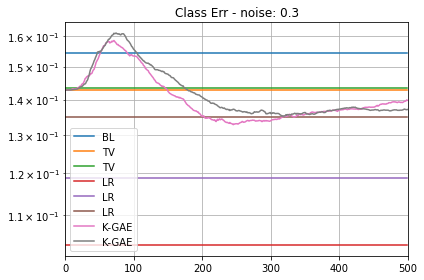

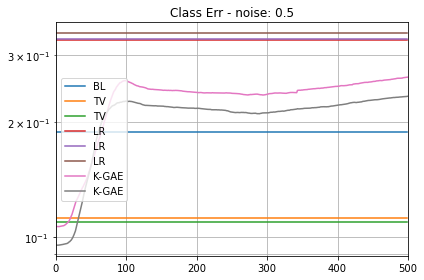

In [ ]:
best_mean_err, std, _ = get_best_err(err2)
fixed_mean_err = np.mean(err, axis=1)[:, :, -1]
fixed_std = np.std(err, axis=1)[:, :, -1]

print_err_all0(labels)
print_err(best_mean_err, std, weights2)
print()
print_err(fixed_mean_err, fixed_std, weights2)

figs = plot_iter_err(np.mean(err, axis=1), 'Class Err - noise')

In [ ]:
# # Save data
# data = {
#     'seed': SEED,
#     'N_P': N_P,
#     'exps': Exps,
#     'err': err,
#     'err2': err2,
#     'lr': lr,
#     'weights': weights,
#     'weights2': weights2,
#     'legend': legend,
#     'fmts': [],
# }
# utils.save_results('cora_baselines', PATH, data)

In [ ]:
plt.show()